## Sampling
This is step is complex. For this section I create two approaches that converge. One is to compute the sample size in the conventional way using the conventional formula  for estimating sample size for a mean is:

n=(Z⋅σ)^2/E^2

Where:

    n = Required sample size.
    Z = Z-score corresponding to the desired confidence level (e.g., 1.96 for a 95% confidence level).
    σ = Estimated population standard deviation (variability).
    E = Margin of error (expressed as a decimal fraction).

The second approach is to propose a random spread of samples in the region that corresponds to agriculture (in the region there are 1618 pixels that correspond to agriculture) and evaluate the standard deviation we would get compared with the soc previously measured. 

## First try

In [93]:
import numpy as np
import scipy.stats as stats

# Load SOC and land cover data
with rasterio.open('data/soc_data.tif') as soc_ds:
    soc_data = soc_ds.read(1)
with rasterio.open('data/reclassified_land_cover.tif') as lc_ds:
    land_cover_data = lc_ds.read(1)

# Define the desired confidence level and margin of error
confidence_level = 0.95  # 95% confidence level
margin_of_error = 0.10  # 10% of the mean value

# Extract SOC values for the agricultural region (where land_cover_data == 3)
agricultural_soc_values = soc_data[land_cover_data == 3]

# Calculate the mean and standard deviation of SOC values in the agricultural region
mean_soc = np.mean(agricultural_soc_values)
std_deviation_soc = np.std(agricultural_soc_values)

# Calculate the critical value for the desired confidence level
z_critical = stats.norm.ppf(1 - (1 - confidence_level) / 2)

# Calculate the required sample size
sample_size = ((z_critical**2) * (std_deviation_soc**2)) / (margin_of_error**2)

# Round up to the nearest integer as sample size must be a whole number
sample_size = np.ceil(sample_size)

print(f"Required Sample Size: {int(sample_size)}")

Required Sample Size: 74958


The computed Sample Size is even bigger than the region of study 

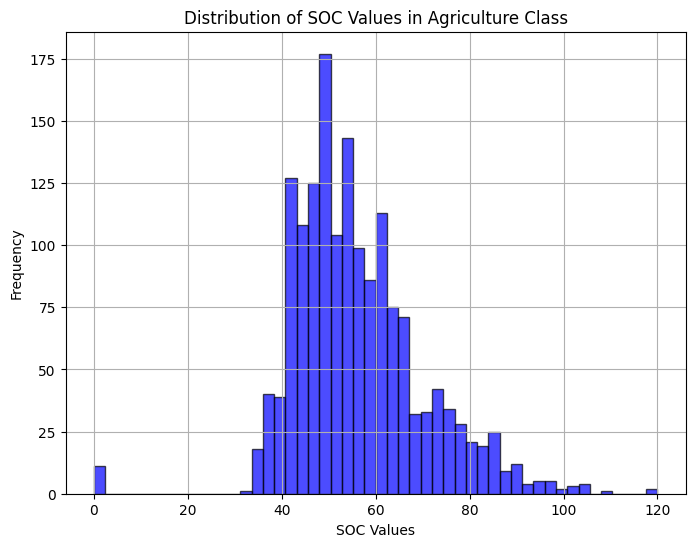

In [94]:
#Just to check if is a good assumtion a Gaussian distribution. 
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load SOC and land cover data
with rasterio.open('data/soc_data.tif') as soc_ds:
    soc_data = soc_ds.read(1)
with rasterio.open('data/reclassified_land_cover.tif') as lc_ds:
    land_cover_data = lc_ds.read(1)

# Get all SOC values for agricultural pixels
agricultural_pixels = soc_data[land_cover_data == 3]
soc_values = agricultural_pixels[~np.isnan(agricultural_pixels)]

# Create a histogram of SOC values
plt.figure(figsize=(8, 6))
plt.hist(soc_values, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of SOC Values in Agriculture Class')
plt.xlabel('SOC Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Second try
The user can change the value of "num_samples" in order to see that even with size similar to the total possible sample size the resulting standard deviation is big and the inteval of confidence small.
The region of study contains 60x40 pixels where 1618 are the pixels that correspond to agriculture.


In [92]:
import numpy as np
import rasterio
import random
from scipy import stats

# Load the SOC data from a TIFF file
with rasterio.open('data/soc_data.tif') as soc_ds:
    soc_data = soc_ds.read(1)

# Load the land cover classification data from a TIFF file
with rasterio.open('data/reclassified_land_cover.tif') as lc_ds:
    land_cover_data = lc_ds.read(1)

# Define the agriculture class value
agriculture_class = 3

# Identify the agricultural pixels
agricultural_pixels = np.where(land_cover_data == agriculture_class)

# Number of samples to spread
num_samples = 1000

# Randomly select 'num_samples' samples from the identified agricultural pixels
selected_samples = random.sample(list(zip(agricultural_pixels[0], agricultural_pixels[1])), num_samples)

# Extract SOC values for the selected samples
soc_samples = [soc_data[sample[0], sample[1]] for sample in selected_samples]

# Calculate mean and standard deviation of selected samples
mean_soc = np.mean(soc_samples)
std_dev_soc = np.std(soc_samples)

# Compute the confidence interval for the mean using Gaussian distribution
confidence_level = 0.95
alpha = 1 - confidence_level
z_value = stats.norm.ppf(1 - alpha / 2)
margin_of_error = z_value * (std_dev_soc / np.sqrt(num_samples))
confidence_interval = (mean_soc - margin_of_error, mean_soc + margin_of_error)

print(f"Sampled Mean SOC: {mean_soc}")
print(f"Standard Deviation of Samples: {std_dev_soc}")
print(f"Confidence Interval ({confidence_level*100}%): {confidence_interval}")


Sampled Mean SOC: 56.26300048828125
Standard Deviation of Samples: 13.658178329467773
Confidence Interval (95.0%): (55.416473380387856, 57.109527596174644)


## Comments of the sampling design

Resolution and Detail: One possible reason for a large required sample size could be the low resolution of the data. Low-resolution data may not capture fine-grained variations in the soil organic carbon (SOC) values within agricultural regions. Increasing the study area or working with higher-resolution data may help capture more detail and reduce uncertainty.

Land Cover Categories: The categorization of land cover into broad classes can impact the required sample size. The "Agriculture" class includes a wide range of agricultural practices and soil types, it might result in higher variability within the class. Further subcategorizing the land cover classes, might help to reduce variability and the required sample size.

Sampling Design Complexity: the sampling design can be complex and is influenced by various factors that should be considered in a more detiailed study such as: topography, land use, soil type. 
